# Problem Set 2 Part b

### Due: 
Collaboration is allowed and encouraged (teams of at most 3).  Please read the syllabus carefully for the guidlines regarding collaboration.  In particular, everyone must write their own solutions in their own words.

### Write your collaborators here:

$\renewcommand{\ket}[1]{\left|{#1}\right\rangle} \renewcommand{\bra}[1]{\left\langle{#1}\right|}$
$\renewcommand{\C}{{\mathbb{C}}}$
$\renewcommand{\N}{{\mathbb{N}}}$
$\renewcommand{\Z}{{\mathbb{Z}}}$


### Recommended Environment to Run This Notebook

We highly recommend that you use the [qBraid](http://www.qbraid.com) platform to run this Jupyter notebook. This supports Qiskit, and furthermore to render your Problem Set solutions to PDF, you have to do the following:

1. File > Save and Export Notebook As > HTML
2. Save the HTML file somewhere on your local computer
3. Open the HTML file using your favorite browser, and Print to PDF. We recommend using Landscape mode so the Python code shows up better.

### Click here to collapse these cells after running the first two

These commands will install qiskit and the qiskit simulator on the Jupyter environment (we recommend qBraid). It may take a few minutes.

In [2]:
!pip install qiskit > /dev/null
!pip install qiskit_aer > /dev/null
!pip install qiskit_ibm_runtime > /dev/null

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_distribution 
from qiskit.result import marginal_distribution

from qiskit_aer import AerSimulator
from qiskit.providers.jobstatus import JobStatus 

from qiskit_ibm_runtime import QiskitRuntimeService

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

In [4]:
# Simulator Setup
shots = 1024
backend_sim = AerSimulator()

In [5]:
# helper method for simulator runs
def fetch_counts(qc:QuantumCircuit(), backend, shots):
    compiled_qc = transpile(qc, backend, optimization_level=0) 
    job_sim = backend.run(compiled_qc, shots=shots)
    results = job_sim.result()
    return results.get_counts()

## Grover's Algorithm

### Grover's oracle
Build a grover's oracle by filling in the following method to try to find the "solution" by searching bit strings of length 3 (i.e. the set [000, 111]) to try to find the string "101". Note that we chose a string that is symmetric so that we may disregard big endianess and little endianess representations. Use an MCX gate (read more here if needed: https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.MCXGate) targeted on the ancilla qubit with control on the "input" qubits or any series of one or two qubit gates. Make sure to reverse any bit-flips or computations so that the "input" qubits are reset appropriately.

In [50]:
def grover_unitary() -> QuantumCircuit():
    qc = QuantumCircuit(3+1)
    ##############################################################################
    # your code here 
    qc.x(1)
    qc.mcx([0, 1, 2], 3)
    
    qc.x(1)
    ##############################################################################
    return qc 

### Grover's Diffuser
Build Grover's diffuser by rotating the input qubits out of the hadamard basis bit flipping them and then apply a MCP(multi-control phase) gate with angle $\pi$ so that it functions as a MCZ gate with target on the last qubit in the "input" qubits. Reset everything as appropriate. Note, this does not depend on the oracle and is the same for every Grover's subroutine.

In [51]:
def grover_diffuser() -> QuantumCircuit():
    qc = QuantumCircuit(3)
    ##############################################################################
    # your code here 
    
    # for the diffuser first apply an H gate to all qubits BESIDES the ancilla
    qc.h([0, 1, 2])
    # then apply X gates to all qubits besides the ancilla
    qc.x([0, 1, 2])
    # now apply the MCZ gate 
    #qc.mcp(np.pi, control_qubits, target_qubit) #applies MCZ
    qc.mcp(np.pi, [0,1],2)
    # undo the X and H gates you applied
    qc.x([0, 1, 2])

    qc.h([0, 1, 2])
        
    ##############################################################################
    return qc 

### Grover's Algorithm 
Calculate the number of iterations of Grover's Algorithm needed for this problem using $k$ iterations calculated by the following equation $k = \frac{\pi}{2\theta} - \frac{1}{2}$ where $\theta = 2sin^{-1}\sqrt{\frac{m}{N}}$. Then run a circuit for k iterations where k denotes the optimal number of iterations. Plot the histograms of the measurement and compare them with the solution.

In [100]:
solution = "101"

grover_of = grover_unitary().to_gate()
grover_of.name = "Oracle"
grover_ud = grover_diffuser().to_gate()
grover_ud.name = "Diffuser"

qc_g = QuantumCircuit(3+1,3)
##############################################################################
# your code here 

# create the initial superposition by putting the input qubits in |+>
# and the ancilla in |->
qc_g.h([0, 1, 2])  
qc_g.x(3)          
qc_g.h(3) 

# iterate the correct amount of times with the oracle and diffuser
# example of how to append the circuits you made earlier
qc_g.append(grover_of, range(4))  
qc_g.append(grover_ud, range(3))

# qc_g.append(grover_uf, range(4))
# qc_g.append(grover_ud, range(3))



##############################################################################
for i in range(3):
    qc_g.measure(i, i)

qc_g.draw()


┌───┐     ┌─────────┐┌───────────┐┌─┐      
q_0: ┤ H ├─────┤0        ├┤0          ├┤M├──────
     ├───┤     │         ││           │└╥┘┌─┐   
q_1: ┤ H ├─────┤1        ├┤1 Diffuser ├─╫─┤M├───
     ├───┤     │  Oracle ││           │ ║ └╥┘┌─┐
q_2: ┤ H ├─────┤2        ├┤2          ├─╫──╫─┤M├
     ├───┤┌───┐│         │└───────────┘ ║  ║ └╥┘
q_3: ┤ X ├┤ H ├┤3        ├──────────────╫──╫──╫─
     └───┘└───┘└─────────┘              ║  ║  ║ 
c: 3/═══════════════════════════════════╩══╩══╩═
                                        0  1  2

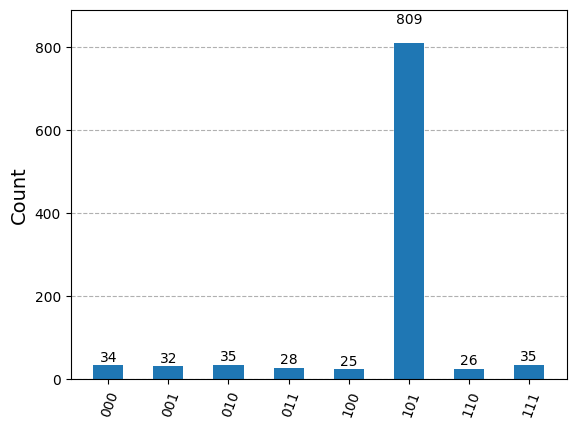

In [101]:
plot_histogram(fetch_counts(qc_g, backend_sim, shots))

Above you should have a spike in the histogram at the solution. What would happen if we measured the ancilla as well? 

## On a Quantum Computer

Next we'll run those same circuit you build on an actual quantum computer...

First you will need to go to https://quantum.ibm.com/account and make an account if you don't already have one. Then under profile settings, scroll down to API token and copy and paste it into the token="your token here" section below.

In [102]:
service = QiskitRuntimeService(channel="ibm_quantum",
                                  token="a3d33491bc98b55092cb8100efead39ddb227c493e1b8a1ec539dab57fe5806193a3f444a3e21c7c809a1983b11d3199aa747238f0e98ea30aa1480ef022baca", 
                                  )

In [103]:
service.backends(min_num_qubits=6)

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_sherbrooke')>]

Use one of the backends available above. Here's an example using IBM Sherbrooke. Feel free to leave it if it is available for you as well.

In [104]:
backend_real = service.backend('ibm_brisbane')

Now this next cell will submit the job to be run on IBM's quantum computer running this cell repeatedly may use up all of your available computer time as each token only has 10 minutes per month. When you are ready, run the job. This will take some time so copy and paste the job_id printed down below into the next cell which checks the status of the job.

In [105]:
compiled_qc_g = transpile(qc_g, backend_real, optimization_level=3)
job = backend_real.run(compiled_qc_g, shots=shots)

print('Job ID:', job.job_id())
job_id = job.job_id()

/tmp/ipykernel_237/723272538.py:2: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = backend_real.run(compiled_qc_g, shots=shots)


Job ID: cxf2z1wfdnwg008s6ykg


Run this cell to check the status of the job. 

In [107]:
job = service.job('cxf2z1wfdnwg008s6ykg')
print(job.status())

/tmp/ipykernel_237/30523175.py:2: DeprecationWarning: In a future release of qiskit-ibm-runtime no sooner than 3 months after the release date of 0.30.0, RuntimeJob.status() will be returned as a string instead of an instance of `JobStatus`. To prepare for this change, you can use the idiom `status.name if isinstance(status, JobStatus) else status`.
  print(job.status())


JobStatus.DONE


Once the job has been completed, run the next cell to get the data from it. 

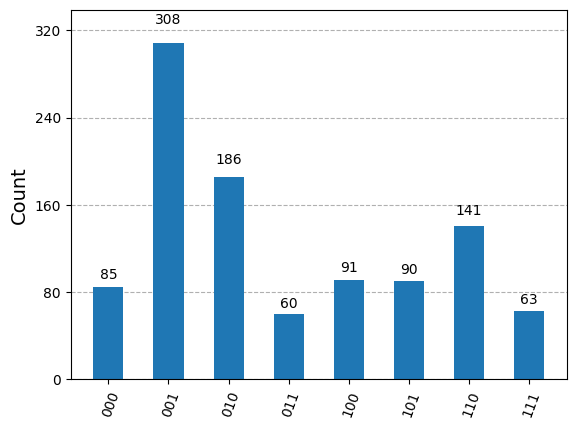

In [108]:
counts = job.result().get_counts() 
plot_histogram(counts)

## Benchmarking individual qubits

In this subproblem, we will benchmark individual qubits on quantum device you just ran on. A typical way to benchmark a qubit is to run a sequence of randomly chosen single-qubit gates $g_1, g_2, ... , g_k$ , and then running the reverse sequence of $g^{−1}_k,...,g^{−1}_1$ so that overall the effect should be the identity. Of course, each gate will incur some noise, so the state of the qubit will drift over time. One can measure the noise by measuring the qubit at the end of the sequence to see if it stayed in the |0⟩ state.

You will write code to perform the following: for $k = 10, 20, 30, ... , 100$, for each qubit $q = 0, 1, 2, ... , 4$, pick a sequence of gates $g_1, ... , g_k$ where each $g_i$ is chosen randomly from the gate set
${X, Y , Z, H}$. Then, on qubit $q$ run the sequence $(g_i)$ forward and then in reverse, and measure the qubit. Do this 1000 times and calculate the percentage $p_{q,k}$ of times that the qubit $q$ ends back in the |0⟩
state.

The function benchmark_qubit, requires you to fill in some code, and it returns a QuantumCircuit object. 

In [2]:
'''
This function takes as input
    -q:qubitnumber0thru4
    - k : length of random gate sequence

  Returns:
    - the QuantumCircuit object corresponding to the circuit
'''
def benchmark_qubit(q, k):
    circ = QuantumCircuit(5, 1)
    gates = ['x', 'y', 'z', 'h']
    ### WRITE CODE TO GENERATE THE RANDOM SEQUENCE OF LENGTH k, and ITS REVERSAL, ON QUBIT q ####################
    sequence = [random.choice(gates) for _ in range(k)]
    for gate in sequence:
        getattr(circ, gate)(q)
    
    for gate in reversed(sequence):
        getattr(circ, gate)(q)   
    ### END CODE BLOCK ###################

    # measure qubit q, and store it in classical register [0]
    circ.measure([q], [0]) 
    return circ

'''
This function takes as input
    - job: the Job object corresponding ot a circuit being executed
    - blocking: if True this will wait until the circuit results are done executing on the device. 
               If false, then this will first check the status of the job.

  Returns:
    - if the job is done, then it returns the counts as a dictionary (e.g., { '0000': 356, '0001': 288, ...})
      otherwise if the job is still running or some other status, then it returns None
'''

def retrieve_job_results(job,blocking=True):
    #if it's blocking, then just go ahead and call result()
    if blocking:
        counts = job.result().get_counts(0) 
        return counts
    else:
        #first, check the status job_status = job.status()
        if job_status is JobStatus.DONE: 
            counts = job.result().get_counts(0) 
            return counts
        else:
            print("The job ",job.job_id," has status: ",job_status) 
            return None


'''
This function takes as input
 -q:qubitnumber0thru4
    - k : length of random gate sequence
    - shots: number of times to run and measure the sequence
    - device: the device to run on, either simulated or real

  Returns:
 - the Job object corresponding to the circuit
'''

def benchmark_qubit_job(q, k, shots, device):
    circ = benchmark_qubit(q,k)
    compiled_circuit = transpile(circ, device, optimization_level=0) 
    job = device.run(compiled_circuit, shots=shots)
    return job

Below is code using benchmark_qubit_job , retrieve_job_results to get the measurement counts and calculate pq,k for q = 0, 1, 2, 3, 4 and k = 10, 20, 30, ... , 100. Then, plot pq,k against k (you can consult https://www.geeksforgeeks.org/using-matplotlib-with-jupyter-notebook/ for an example on how to plot graphs). You should have 5 plots in one graph. 

Warning this cell will also run on the quantum computer so it will also take sometime to run (8-10 hours though most of this is time waiting in queue). It will perform each job and write their job IDs to a file and then read from a file. IF at any point this process gets interupted you can rerun the cell and the code will use the output file to pick up where it left off. Do not modify the output file. There may be some depreciation warnings.

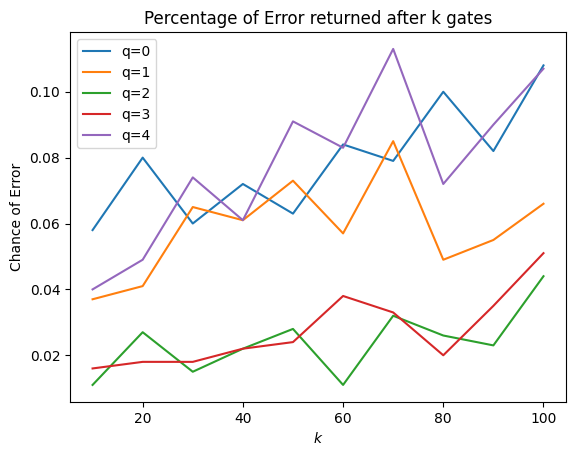

In [110]:
def output_helper(job_id: str) -> int:
    filename = "output.txt"
    
    if not os.path.exists(filename):
        with open(filename, "w") as f:
            f.write(new_line_content)
    else:
        if job_id != '':
            with open(filename, "a") as f:
                f.write(str(job_id) + '\n')
            print(f"Appended a new line {job_id} to {filename}.")

    with open(filename, "r") as f:
        lines = f.readlines()
    
    return len(lines)

def read_output(line_number: int) -> str:
    filename = "output.txt"
    with open(filename, "r") as f:
        lines = f.readlines()
        if 0 <= line_number < len(lines):
            return lines[line_number].rstrip('\n')
        else:
            return None
    

k_counts = []
k_groups = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 
qubits = [0, 1, 2, 3, 4]
p_qk = [[],[],[],[],[]]

index = f"{output_helper(''):02d}" # reads the num of jobs processed
index_q = int(str(index)[0])
index_k = int(str(index)[1])
index = int(index)
for i in range(index_q, len(qubits)):
    q = qubits[i]
    for j in range(index_k, len(k_groups)):
        k = k_groups[j]
        output_helper(benchmark_qubit_job(q, k, 1000, backend_real).job_id())
        retrieve_job_results(service.job(read_output(index)))
        index += 1

index = 0
for q in qubits: # runs 5 times
    q_count = []
    for k in k_groups: # runs 10 times
        job = service.job(read_output(index))
        q_count.append(job.result().get_counts()) 
        index += 1
        
    k_counts.append(q_count) 

for q in qubits:
    for i in range(len(k_groups)):
        p_qk[q].append(1 - k_counts[q][i]['0']/1000)

    plt.plot(k_groups, p_qk[q], label=f'q={q}')
plt.xlabel('$k$')
plt.ylabel('Chance of Error')
plt.title('Percentage of Error returned after k gates') 
plt.legend()
plt.show()

### Estimating single qubit gate noise

For each qubit q, find a best function f(k) (linear, quadratic, exponential,...) that fits the plots. For example, if the plot of pqk against k looks linear, then you should come up with parameters a, b such that pqk is close to ak + b. If it looks like exponential decay, then you should find an approximate f(k) = aebk + c for some parameters a, b, c.
This function can be used to give a simple model for how noise accumulates on each qubit from single-qubit gates.

## Benchmarking entanglement generation (optional)

Everything below this point is optional but is the same as the single qubit part but now for two entangled qubits.

Now we benchmark the quantum computer on more complex circuits that involve entangling gates, which will generally be more noisy than single-qubit gates. For each $r = 2, 3, 4, 5$, let $|ψ_r⟩$ denote the $r$-qubit GHZ state
$|0⟩^{⊗r} + |1⟩^{⊗r} /√2 .

When $r = 2$, this is simply the EPR pair we know and love. Let $C_r$ denote a circuit that starts with $r$ zeroes and outputs $|ψ_r⟩$.



Write code to do the same benchmarking as in the previous problem, except now we perform $C_r$, then $C^{−1}$ then $C_r$, and so on $k$ times. Ideally, all of these circuits would cancel out so measuring all $r$ qubits will yeild zero. However, the gates will be noisy so error will accumulate as $k$ grows larger.
Let $p_{rk}$ denote the percentage of times (out of 1000 shots) that doing $C_r$ and $C^{−1}$ for $k$ times yields all zeroes in the $r$ qubits. Plot $p_{rk}$ versus $k$ for $r = 2, 3, 4, 5$ and for $k = 10, 20, 30, ... , 100$. There should be 4 plots on one graph.

*Important:* The real device you chose has very particular connectivity of qubits which you can find here: https://quantum.ibm.com/services/resources

You can only apply 2-qubit gates between the connected nodes. For exampe, you can apply a CNOT between qubits 3 and 1, but not 3 and 2. Thus, when coding your circuit $C_r$, you may want to judiciously choose which $r$ qubits you use to maximize the performance. The darker shading of a qubit means lower noise rate.

In [11]:
!pip install qiskit > /dev/null
!pip install qiskit_aer > /dev/null
!pip install qiskit_ibm_runtime > /dev/null

In [12]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_distribution 
from qiskit.result import marginal_distribution

from qiskit_aer import AerSimulator
from qiskit.providers.jobstatus import JobStatus 

from qiskit_ibm_runtime import QiskitRuntimeService

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

In [13]:
service = QiskitRuntimeService(channel="ibm_quantum",
                                  token="a3d33491bc98b55092cb8100efead39ddb227c493e1b8a1ec539dab57fe5806193a3f444a3e21c7c809a1983b11d3199aa747238f0e98ea30aa1480ef022baca", 
                                  )

In [14]:
service.backends(min_num_qubits=6)

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_sherbrooke')>]

In [15]:
backend_real = service.backend('ibm_brisbane')

/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfjzgefdnwg008s8s1g to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfjzmyky7rg0083ttvg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfjzsfvw7kg008s2210 to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfjzy7gcckg008sakzg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk0286t010008cjp60 to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk06g3ej4g008g1gsg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk0b9vw7kg008s226g to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk5myky7rg0083tw10 to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk5s7vw7kg008s23bg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk5xf6t010008cjqbg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk620fdnwg008s8tdg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk6606t010008cjqd0 to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk6a9gcckg008san50 to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk6f16t010008cjqfg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk6kafdnwg008s8tk0 to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk6qjvw7kg008s23jg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk6vv6t010008cjqkg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk70w6t010008cjqng to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk75cgcckg008san9g to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk7a5vw7kg008s23rg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk7ex3ej4g008g1j7g to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk7k6fdnwg008s8tp0 to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk7qy3ej4g008g1j8g to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk7y73ej4g008g1jb0 to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk820ky7rg0083twf0 to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk86ggcckg008sanfg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk8b16t010008cjqxg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk8fs6t010008cjqz0 to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk8mjvw7kg008s2420 to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk8sb3ej4g008g1jfg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk8ybvw7kg008s245g to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk92cfdnwg008s8tyg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk96mvw7kg008s2490 to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk9bdky7rg0083twqg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk9fxfdnwg008s8v1g to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk9ny6t010008cjr7g to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk9tfky7rg0083twt0 to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfk9z7gcckg008sanxg to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfka406t010008cjrc0 to optionaloutput.txt.


/tmp/ipykernel_727/4163659343.py:60: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = device.run(compiled_circuit,shots=shots)


Appended a new line cxfkaa1gcckg008sap00 to optionaloutput.txt.


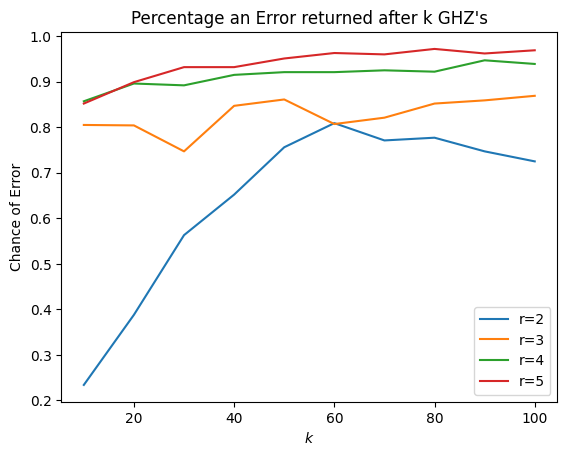

In [16]:
'''
 This function takes as input
 -r:sizeofGHZstate
    - k : length of random gate sequence

  Returns:
 - the QuantumCircuit object corresponding to the circuit 
'''

def benchmark_circuit(r, k):
    circ = QuantumCircuit(5, r)
### WRITE CODE TO GENERATE C_r and its reversal k times ####################
    
    for _ in range(k):
        # Apply Cr (Controlled gates, e.g., CNOT)
        for i in range(r-1):
            circ.cx(i, i+1)  # CNOT between qubits i and i+1
        # Apply C-1 (inverse of Cr)
        for i in range(r-1):
            circ.cx(i, i+1)        
    ### END CODE BLOCK ###################

    ### WRITE CODE TO MEASURE AND COMPUTE P_RK #####################
    # measure r of the qubits , and store it in the r classical registers
    #for example, if r = 3, circ.measure([1,3,4],[0,1,2]) would mean measuring qubits 1,3,4
 
    circ.measure(range(r), range(r))
        
    ### END CODE BLOCK ###################
    return circ
    
'''
 This function takes as input
 -r:sizeofGHZstate
    - k : length of random gate sequence
    - shots: number of times to run and measure the sequence
    - device: the device to run on, either simulated or real

  Returns:
 - the IBMQJob object corresponding to the circuit 
'''

def retrieve_job_results_2(job,blocking=True):
    #if it's blocking, then just go ahead and call result()
    if blocking:
        counts = job.result().get_counts(0) 
        return counts
    else:
        #first, check the status job_status = job.status()
        if job_status is JobStatus.DONE: 
            counts = job.result().get_counts(0) 
            return counts
        else:
            print("The job ",job.job_id," has status: ",job_status) 
            return None

def benchmark_circuit_job(r, k, shots, device):
    circ = benchmark_circuit(r,k)
    compiled_circuit = transpile(circ, device, optimization_level=0) 
    job = device.run(compiled_circuit,shots=shots)
    return job

def output_helper_2(job_id: str) -> int:
    filename = "optionaloutput.txt"
    
    if not os.path.exists(filename):
        with open(filename, "w") as f:
            f.write(new_line_content)
    else:
        if job_id != '':
            with open(filename, "a") as f:
                f.write(str(job_id) + '\n')
            print(f"Appended a new line {job_id} to {filename}.")

    with open(filename, "r") as f:
        lines = f.readlines()
    
    return len(lines)

def read_output_2(line_number: int) -> str:
    filename = "optionaloutput.txt"
    with open(filename, "r") as f:
        lines = f.readlines()
        if 0 <= line_number < len(lines):
            return lines[line_number].rstrip('\n')
        else:
            return None
            
k_count = []
k_groups = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 
ghzs = [2, 3, 4, 5]
p_rk = [[],[],[],[]]

index = f"{output_helper_2(''):02d}" # reads the num of jobs processed
index_q = int(str(index)[0])
index_k = int(str(index)[1])
index = int(index)
for i in range(index_q, len(ghzs)):
    q = ghzs[i]
    for j in range(index_k, len(k_groups)):
        k = k_groups[j]
        output_helper_2(benchmark_circuit_job(q, k, 1000, backend_real).job_id())
        retrieve_job_results_2(service.job(read_output_2(index)))
        index += 1

index = 0
for q in ghzs: # runs 5 times
    q_count = []
    for k in k_groups: # runs 10 times
        job = service.job(read_output_2(index))
        q_count.append(job.result().get_counts()) 
        index += 1
        
    k_count.append(q_count) 

for idx, r in enumerate(ghzs):
    for i in range(len(k_groups)):
        all_zero_key = '0' * r
        p_rk[idx].append(1 - k_count[idx][i].get(all_zero_key, 0)/1000)

    plt.plot(k_groups, p_rk[idx], label=f'r={r}')

#### END CODE BLOCK ############################################################

plt.xlabel('$k$')
plt.ylabel('Chance of Error')
plt.title('Percentage an Error returned after k GHZ\'s') 
plt.legend()
plt.show()

### Estimating noise of the GHZ circuit

For each r = 2, 3, 4, 5 find a best function f(k) (linear, quadratic, exponential,...) that fits the plots.
These functions can be used to give a simple model for how noise accumulates at a global level for the GHZ circuit. How much worse is this than the single-qubit gates situation?

### Solution:
The noise in the GHZ circuit increases with $k$ and can be modeled by an exponential function:
\
$p_{rk}$ = $p_0 e^{-\alpha k}$

where $p_0$ is the initial success rate and \( \alpha \) is a noise parameter. The GHZ circuit accumulates noise faster than single-qubit gates due to entangling gates, which propagate noise across qubits. The noise difference can be expressed as:
\
\$delta$ $p_{r,k} = p_{r,k} - p_{1,k}$


indicating that the noise in GHZ circuits grows more rapidly with $r$ and $k$ compared to single-qubit gates.

#### Single-Qubit Gates:
Noise accumulation is relatively low, with most error rates decreasing (qubits 0 and 4) or staying stable (qubits 1 and 2).
The functions are either linear or exponential decay, indicating that noise is more manageable.

#### GHZ Circuits:

Noise accumulation is significantly higher, especially for larger r.
Functions are linear or exponential growth, indicating that entanglement amplifies noise due to its sensitivity to errors across multiple qubits.

#### Conclusion:

GHZ circuits accumulate noise much faster than single-qubit gates due to their multi-qubit entanglement and the global sensitivity of the state.
For r=5, the error rate approaches 1, which is far worse than any single-qubit behavior.
